In [146]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# Load dataset and initialize dataloader
BATCH_SIZE = 16

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = datasets.CIFAR10(root="~/data",
                           download=True,
                           train=False,
                           transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2)

truncated_testset, _ = torch.utils.data.random_split(testset, [1000, 9000])

truncated_testloader = torch.utils.data.DataLoader(truncated_testset,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=2)

Files already downloaded and verified


In [149]:
# Load the trained resnet model
PATH = "/content/RESNET_CLASSIFIER_L.pth"
resnet = torch.load(PATH)

In [150]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [151]:
device = torch.device("cuda")

In [152]:
# Checking accuracy on clean images
correct, total = 0, 0
with torch.no_grad():
  for i, data in enumerate(truncated_testloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = resnet(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted==labels).sum().item()

  print(f"Accuracy on 1000 clean images: {correct/total*100}")

Accuracy on 1000 clean images: 85.5


In [153]:
torch.cuda.empty_cache()

Fast Gradient Method

In [154]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

In [160]:
epsilon = 0.1
clip_min = 0.0
clip_max = 1.0
norm = np.inf

correct, total = 0, 0
total_time = 0.0

for i, data in enumerate(truncated_testloader):
  start_time, end_time = 0.0, 0.0
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  start_time = time.time()

  adversarial_inputs = fast_gradient_method(resnet,
                                            inputs,
                                            eps=epsilon,
                                            norm=norm,
                                            clip_min=clip_min,
                                            clip_max=clip_max,
                                            y=labels,
                                            targeted=False)

  end_time = time.time()
  
  outputs = resnet(adversarial_inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  total_time += (end_time - start_time)

  if (i+1)%10==0:
    print(f"Completed: {i*BATCH_SIZE} with accuracy of {correct/total*100}")

print(f"Accuracy on attacked 1000 adversarial examples using Fast Gradient Method: {correct/total*100} with time: {total_time} seconds")

Completed: 144 with accuracy of 6.25
Completed: 304 with accuracy of 7.187499999999999
Completed: 464 with accuracy of 7.291666666666667
Completed: 624 with accuracy of 7.968749999999999
Completed: 784 with accuracy of 8.125
Completed: 944 with accuracy of 8.125
Accuracy on attacked 1000 adversarial examples using Fast Gradient Method: 8.0 with time: 5.947423934936523 seconds


In [161]:
torch.cuda.empty_cache()

In [162]:
import time

Projected Gradient Descent

In [163]:
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [164]:
epsilon = 0.1
clip_min = 0.0
clip_max = 1.0
norm = np.inf
eps_iter = 0.05
nb_iter = 20

correct, total = 0, 0
total_time = 0.0

for i, data in enumerate(truncated_testloader):
  start_time, end_time = 0.0, 0.0
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  start_time = time.time()
  adversarial_inputs = projected_gradient_descent(resnet,
                                                  inputs,
                                                  eps=epsilon,
                                                  eps_iter=eps_iter,
                                                  nb_iter=nb_iter,
                                                  norm=norm)

  end_time = time.time()

  outputs = resnet(adversarial_inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  total_time += (end_time - start_time)

  if (i+1)%10==0:
    print(f"Completed: {i*BATCH_SIZE} with accuracy of {correct/total*100}")

print(f"Accuracy on attacked 1000 adversarial examples using Projected Gradient Descent: {correct/total*100} with time: {total_time} seconds")

Completed: 144 with accuracy of 2.5
Completed: 304 with accuracy of 2.8125
Completed: 464 with accuracy of 2.7083333333333335
Completed: 624 with accuracy of 2.5
Completed: 784 with accuracy of 2.625
Completed: 944 with accuracy of 2.5
Accuracy on attacked 1000 adversarial examples using Projected Gradient Descent: 2.4 with time: 125.15714573860168 seconds


In [175]:
torch.cuda.empty_cache()

Carlini and Wagner L2 Attack

In [177]:
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2

In [178]:
n_classes = 10

correct, total = 0, 0
total_time = 0.0

for i, data in enumerate(truncated_testloader):
  start_time, end_time = 0.0, 0.0
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  start_time = time.time()

  adversarial_inputs = carlini_wagner_l2(resnet,
                                         inputs,
                                         n_classes=n_classes,
                                         targeted=False,
                                         binary_search_steps=3,
                                         max_iterations=100,
                                         initial_const=0.01,
                                         lr=0.01,
                                         confidence=0.1)

  end_time = time.time()

  outputs = resnet(adversarial_inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  total_time += (end_time - start_time)

  if (i+1)%10==0:
    print(f"Completed: {i*BATCH_SIZE} with accuracy of {correct/total*100} with time: {total_time} seconds")

print(f"Accuracy on attacked 1000 adversarial examples using Carlini and Wagner L2 Attack: {correct/total*100} with time: {total_time} seconds")

Completed: 144 with accuracy of 2.5 with time: 295.87879252433777 seconds
Completed: 304 with accuracy of 3.75 with time: 596.5709054470062 seconds
Completed: 464 with accuracy of 5.208333333333334 with time: 897.1838102340698 seconds
Completed: 624 with accuracy of 4.84375 with time: 1197.4947290420532 seconds
Completed: 784 with accuracy of 4.5 with time: 1497.5962183475494 seconds
Completed: 944 with accuracy of 4.270833333333333 with time: 1797.9963812828064 seconds
Accuracy on attacked 1000 adversarial examples using Carlini and Wagner L2 Attack: 4.3 with time: 1874.8635625839233 seconds


In [113]:
torch.cuda.empty_cache()

Noise

In [166]:
from cleverhans.torch.attacks.noise import noise

In [167]:
epsilon = 0.1
order = np.inf

correct, total = 0, 0
total_time = 0.0

for i, data in enumerate(truncated_testloader):
  start_time, end_time = 0.0, 0.0
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  start_time = time.time()

  adversarial_inputs = noise(inputs,
                             eps=epsilon,
                             order=order)

  end_time = time.time()

  outputs = resnet(adversarial_inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  total_time += (end_time - start_time)

  if (i+1)%10==0:
    print(f"Completed: {i*BATCH_SIZE} with accuracy of {correct/total*100}")

print(f"Accuracy on attacked 1000 adversarial examples using Noise attack: {correct/total*100} with time: {total_time} seconds")

Completed: 144 with accuracy of 30.0
Completed: 304 with accuracy of 34.375
Completed: 464 with accuracy of 33.958333333333336
Completed: 624 with accuracy of 35.3125
Completed: 784 with accuracy of 34.625
Completed: 944 with accuracy of 34.375
Accuracy on attacked 1000 adversarial examples using Noise attack: 34.5 with time: 0.14503002166748047 seconds


In [170]:
torch.cuda.empty_cache()

Sparse L1 Descent

In [171]:
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent

In [174]:
epsilon=0.1
eps_iter=0.05
nb_iter=20,
grad_sparsity=50

correct, total = 0, 0
total_time = 0.0

for i, data in enumerate(truncated_testloader):
  start_time, end_time = 0.0, 0.0

  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)

  start_time = time.time()

  adversarial_inputs = sparse_l1_descent(resnet,
                                         inputs,
                                         eps=epsilon,
                                         eps_iter=0.05,
                                         nb_iter=20,
                                         targeted=False,
                                         rand_init=False,
                                         clip_grad=False,
                                         grad_sparsity=grad_sparsity,
                                         sanity_checks=True)
  end_time = time.time()

  outputs = resnet(adversarial_inputs)

  _, predicted = torch.max(outputs.data, 1)

  total += labels.size(0)
  correct += (predicted==labels).sum().item()

  total_time = (end_time - start_time)

  if (i+1)%10==0:
    print(f"Completed: {i*BATCH_SIZE} with accuracy of {correct/total*100}")

print(f"Accuracy on attacked 1000 adversarial examples using Sparse L1 Descent: {correct/total*100} with time: {total_time} min")

Completed: 144 with accuracy of 85.625
Completed: 304 with accuracy of 84.6875
Completed: 464 with accuracy of 85.0
Completed: 624 with accuracy of 84.84375
Completed: 784 with accuracy of 84.625
Completed: 944 with accuracy of 85.3125
Accuracy on attacked 1000 adversarial examples using Sparse L1 Descent: 85.5 with time: 1.0810728073120117 min


In [179]:
time_taken = {"fast_gradient_method": 5.95,
              "projected_gradient_descent": 125.16,
              "carlini_wagner_l2": 1847.86,
              "noise":0.15,
              "sparse_l1_descent": 64.87}

Plotting Respective Atack times

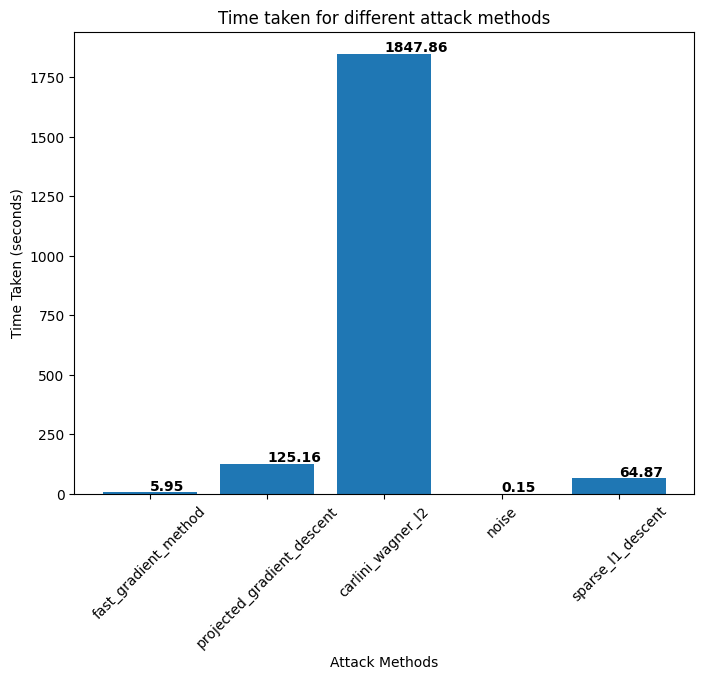

In [182]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(time_taken.keys(), time_taken.values())

# Add labels and title
ax.set_xlabel("Attack Methods")
ax.set_ylabel("Time Taken (seconds)")
ax.set_title("Time taken for different attack methods")

# Add text labels to the plot
for i, v in enumerate(time_taken.values()):
    ax.text(i, v + 10, str(v), color='black', fontweight='bold')

# Rotate x-tick labels
plt.xticks(rotation=45)

# Show the plot
plt.show()